In [1]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import plotly.graph_objects as go
import ruptures as rpt
from itertools import combinations as comb
from statsmodels.stats import power
import numpy as np
from scipy import stats
from scipy.signal import find_peaks

from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from scipy.spatial.distance import cdist
import colorsys

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
cpd_model = rpt.Binseg(model = 'l2',jump=500, min_size=4500)
def change_point_detection(df, throw_away = 0.1):
    """
    Changepoint Detection
    Input: - df:  from read_data
           - key: which is the filename
           - throw_away: everything smaller than 10% of the total length of data is thrown away

    Returns: - return_dict: A dictionary with all the data and the format key_cnt
    """
    signal = df[['accelerometer_x','accelerometer_y','accelerometer_z']].values
    length = len(df)
    algo = cpd_model.fit(signal)
    result = [0]
    result += algo.predict(pen=1000)
    if result[-1] != length:
        result += [length]
        
    return_df = pd.DataFrame()
    for i in range(len(result)-1):
        if (result[i+1]-result[i]) > 4500:
            if return_df.empty:
                return_df = df.iloc[result[i]:result[i+1]]
            else:
                return_df = pd.concat([return_df, df.iloc[result[i]:result[i+1]]],ignore_index=True)
       
    """
    This is the seperated version, so we dont have windows that belong to different changepoint sections
    return_dict = {}
    cnt = 1
    for i in range(len(result)-1):
        if result[i+1]-result[i] > length*throw_away:
            return_dict[key+'_'+str(cnt)] = df.iloc[result[i]:result[i+1]]
            cnt+=1
    """
    return return_df

In [3]:
folder_path = 'data'
def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'),sep=';')
    accelerometer['Time (s)'] = pd.to_datetime(accelerometer['Time (s)'], unit='s')
    accelerometer =accelerometer.set_index('Time (s)')
    accelerometer = accelerometer.resample('2.5ms').mean()
    accelerometer.rename(columns={'Acceleration x (m/s^2)':'accelerometer_x','Acceleration y (m/s^2)':'accelerometer_y','Acceleration z (m/s^2)':'accelerometer_z'}, inplace=True)
    #accelerometer = accelerometer[9000:-9000]
    accelerometer.reset_index(inplace=True)

    
    gyroscope = pd.read_csv(os.path.join(folder_path, filename,'Gyroscope.csv'),sep=';')
    gyroscope['Time (s)'] = pd.to_datetime(gyroscope['Time (s)'], unit='s')
    gyroscope =gyroscope.set_index('Time (s)')
    gyroscope = gyroscope.resample('2.5ms').mean()
    gyroscope.rename(columns={'Gyroscope x (rad/s)':'gyroscope_x','Gyroscope y (rad/s)':'gyroscope_y','Gyroscope z (rad/s)':'gyroscope_z'}, inplace=True)
    #gyroscope = gyroscope[9000:-9000]
    gyroscope.reset_index(inplace=True)
    merged = pd.merge(accelerometer,gyroscope, on= 'Time (s)', how='inner')
    #return merged
    return change_point_detection(merged)
    

In [4]:
# regex to delete the number at the end of the string:
def delete_number(string):
    return ''.join([i for i in string if not i.isdigit()])

In [5]:
data_dict = {}
name_to_idx = {} # name -> idx
i = 0

for name in tqdm(sorted(os.listdir(folder_path))):
    data_dict[name] = read_data(name)
    data_dict[name].set_index('Time (s)', inplace=True)
    data_dict[name].interpolate(inplace=True, method="time")

    # add label
    if delete_number(name) not in name_to_idx.keys():
        name_to_idx[delete_number(name)] = i
        i+=1

100%|███████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:30<00:00,  1.40s/it]


In [6]:
def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

# Apply normalization per person <- per walk
#for key in data_dict.keys():
#    data_dict[key] = min_max_normalize(data_dict[key])

In [7]:
def add_feature(axis_list, axis, X_train, appendix=""):
    #mean
    X_train[axis+'_mean'+appendix] = pd.Series(axis_list).apply(lambda x: x.mean())
    #std dev
    X_train[axis+'_std'+appendix] = pd.Series(axis_list).apply(lambda x: x.std())
    #avg absolute difference
    X_train[axis+'_aad'+appendix] = pd.Series(axis_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    #min
    X_train[axis+'_min'+appendix] = pd.Series(axis_list).apply(lambda x: x.min())
    #max
    X_train[axis+'_max'+appendix] = pd.Series(axis_list).apply(lambda x: x.max())
    #max-min diff
    X_train[axis+'_maxmin_diff'+appendix] = X_train[axis+'_max'+appendix] - X_train[axis+'_min'+appendix]
    #median
    X_train[axis+'_median'+appendix] = pd.Series(axis_list).apply(lambda x: np.median(x))
    #median absolut deviation
    X_train[axis+'_mad'+appendix] = pd.Series(axis_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    #interquartile range
    X_train[axis+'_IQR'+appendix] = pd.Series(axis_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    if appendix != "_fft":
        #negative count
        X_train[axis+'_neg_count'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x < 0))
        #positive count
        X_train[axis+'_pos_count'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x > 0))
    
    #values above mean
    X_train[axis+'_above_mean'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x > x.mean()))
    #number of peaks
    X_train[axis+'_peak_count'+appendix] = pd.Series(axis_list).apply(lambda x: len(find_peaks(x)[0]))
    #skewness
    X_train[axis+'_skewness'+appendix] = pd.Series(axis_list).apply(lambda x: stats.skew(x))
    #kurtosis
    X_train[axis+'_kurtosis'+appendix] = pd.Series(axis_list).apply(lambda x: stats.kurtosis(x))
    # energy
    X_train[axis+'_energy'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x**2)/100)

    return X_train

In [8]:
verification_keys = [] # "nick2", "till2", "uta2", "paula2"

In [9]:
name_to_idx

{'chris': 0,
 'felix': 1,
 'katarina': 2,
 'kirill': 3,
 'leon': 4,
 'leonie': 5,
 'lucas': 6,
 'luisa': 7,
 'melna': 8,
 'nele': 9,
 'nick': 10,
 'paula': 11,
 'rebecca': 12,
 'till': 13,
 'uta': 14}

In [23]:
# Initializing lists
x_list = []
y_list = []
z_list = []

x_val_list = []
y_val_list = []
z_val_list = []
val_labels = []

train_labels = []
x_test_list = []
y_test_list = []
z_test_list = []
test_labels = []

gx_list = []
gy_list = []
gz_list = []

gx_val_list = []
gy_val_list = []
gz_val_list = []

gx_test_list = []
gy_test_list = []
gz_test_list = []

window_size = 410 * 5 # we give the model 5 steps
step_size = 410 # 82

# Creating overlapping windows of size window_size
for name, df_train in data_dict.items():
    label = name_to_idx[delete_number(name)]
    n_train_end = int(df_train.shape[0] * 0.7)  # 70% train
    n_test_end = int(df_train.shape[0] * 0.85)  # next 15% test (and the last 15% for val)

    # Training data
    for i in range(0, n_train_end - window_size, step_size):
        xs = df_train['accelerometer_x'].values[i: i + window_size]
        ys = df_train['accelerometer_y'].values[i: i + window_size]
        zs = df_train['accelerometer_z'].values[i: i + window_size]
        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        train_labels.append(label)
        
        gxs = df_train['gyroscope_x'].values[i: i + window_size]
        gys = df_train['gyroscope_y'].values[i: i + window_size]
        gzs = df_train['gyroscope_z'].values[i: i + window_size]
        gx_list.append(gxs)
        gy_list.append(gys)
        gz_list.append(gzs)
    
    # Testing data
    for i in range(n_train_end, n_test_end - window_size, step_size):
        xs = df_train['accelerometer_x'].values[i: i + window_size]
        ys = df_train['accelerometer_y'].values[i: i + window_size]
        zs = df_train['accelerometer_z'].values[i: i + window_size]
        x_test_list.append(xs)
        y_test_list.append(ys)
        z_test_list.append(zs)
        test_labels.append(label)

        gxs = df_train['gyroscope_x'].values[i: i + window_size]
        gys = df_train['gyroscope_y'].values[i: i + window_size]
        gzs = df_train['gyroscope_z'].values[i: i + window_size]
        gx_test_list.append(gxs)
        gy_test_list.append(gys)
        gz_test_list.append(gzs)

    # Validation data
    for i in range(n_test_end, df_train.shape[0] - window_size, step_size):
        xs = df_train['accelerometer_x'].values[i: i + window_size]
        ys = df_train['accelerometer_y'].values[i: i + window_size]
        zs = df_train['accelerometer_z'].values[i: i + window_size]
        x_val_list.append(xs)
        y_val_list.append(ys)
        z_val_list.append(zs)
        val_labels.append(label)

        gxs = df_train['gyroscope_x'].values[i: i + window_size]
        gys = df_train['gyroscope_y'].values[i: i + window_size]
        gzs = df_train['gyroscope_z'].values[i: i + window_size]
        gx_val_list.append(gxs)
        gy_val_list.append(gys)
        gz_val_list.append(gzs)

def calculate_magnitude_mean(x_list, y_list, z_list):
    return [((pd.Series(x_list[i])**2 + pd.Series(y_list[i])**2 + pd.Series(z_list[i])**2)**0.5).mean() for i in range(len(x_list))]

def calculate_sma(x_list, y_list, z_list):
    """ Calculates the signal magnitude area. """
    return (pd.Series(x_list).apply(lambda x: np.sum(abs(x)/window_size)) +
            pd.Series(y_list).apply(lambda x: np.sum(abs(x)/window_size)) +
            pd.Series(z_list).apply(lambda x: np.sum(abs(x)/window_size)))

def calculate_fft_features(data_list, prefix, df):
    fft_list = pd.Series(data_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
    df = add_feature(fft_list, prefix, df, "_fft")
    return df, fft_list

# Train
X_train = pd.DataFrame()
X_train = add_feature(x_list, 'x', X_train)
X_train = add_feature(y_list, 'y', X_train)
X_train = add_feature(z_list, 'z', X_train)
X_train['avg_result_accl'] = calculate_magnitude_mean(x_list, y_list, z_list)
X_train['sma'] = calculate_sma(x_list, y_list, z_list)
X_train, x_fft_list = calculate_fft_features(x_list, 'x', X_train)
X_train, y_fft_list = calculate_fft_features(y_list, 'y', X_train)
X_train, z_fft_list = calculate_fft_features(z_list, 'z', X_train)
X_train['avg_result_accl_fft'] = calculate_magnitude_mean(x_fft_list, y_fft_list, z_fft_list)
X_train['sma_fft'] = calculate_sma(x_fft_list, y_fft_list, z_fft_list)

X_train = add_feature(gx_list, 'gx', X_train)
X_train = add_feature(gy_list, 'gy', X_train)
X_train = add_feature(gz_list, 'gz', X_train)
X_train['avg_result_gyro'] = calculate_magnitude_mean(gx_list, gy_list, gz_list)
X_train['sma_gyro'] = calculate_sma(gx_list, gy_list, gz_list)
X_train, gx_fft_list = calculate_fft_features(gx_list, 'gx', X_train)
X_train, gy_fft_list = calculate_fft_features(gy_list, 'gy', X_train)
X_train, gz_fft_list = calculate_fft_features(gz_list, 'gz', X_train)
X_train['avg_result_gyro_fft'] = calculate_magnitude_mean(gx_fft_list, gy_fft_list, gz_fft_list)
X_train['sma_gyro_fft'] = calculate_sma(gx_fft_list, gy_fft_list, gz_fft_list)

y_train = np.array(train_labels)

# Validation
X_val = pd.DataFrame()
X_val = add_feature(x_val_list, 'x', X_val)
X_val = add_feature(y_val_list, 'y', X_val)
X_val = add_feature(z_val_list, 'z', X_val)
X_val['avg_result_accl'] = calculate_magnitude_mean(x_val_list, y_val_list, z_val_list)
X_val['sma'] = calculate_sma(x_val_list, y_val_list, z_val_list)
X_val, x_val_fft_list = calculate_fft_features(x_val_list, 'x', X_val)
X_val, y_val_fft_list = calculate_fft_features(y_val_list, 'y', X_val)
X_val, z_val_fft_list = calculate_fft_features(z_val_list, 'z', X_val)
X_val['avg_result_accl_fft'] = calculate_magnitude_mean(x_val_fft_list, y_val_fft_list, z_val_fft_list)
X_val['sma_fft'] = calculate_sma(x_val_fft_list, y_val_fft_list, z_val_fft_list)

X_val = add_feature(gx_val_list, 'gx', X_val)
X_val = add_feature(gy_val_list, 'gy', X_val)
X_val = add_feature(gz_val_list, 'gz', X_val)
X_val['avg_result_gyro'] = calculate_magnitude_mean(gx_val_list, gy_val_list, gz_val_list)
X_val['sma_gyro'] = calculate_sma(gx_val_list, gy_val_list, gz_val_list)
X_val, gx_val_fft_list = calculate_fft_features(gx_val_list, 'gx', X_val)
X_val, gy_val_fft_list = calculate_fft_features(gy_val_list, 'gy', X_val)
X_val, gz_val_fft_list = calculate_fft_features(gz_val_list, 'gz', X_val)
X_val['avg_result_gyro_fft'] = calculate_magnitude_mean(gx_val_fft_list, gy_val_fft_list, gz_val_fft_list)
X_val['sma_gyro_fft'] = calculate_sma(gx_val_fft_list, gy_val_fft_list, gz_val_fft_list)

y_val = np.array(val_labels)

# Test
X_test = pd.DataFrame()
X_test = add_feature(x_test_list, 'x', X_test)
X_test = add_feature(y_test_list, 'y', X_test)
X_test = add_feature(z_test_list, 'z', X_test)
X_test['avg_result_accl'] = calculate_magnitude_mean(x_test_list, y_test_list, z_test_list)
X_test['sma'] = calculate_sma(x_test_list, y_test_list, z_test_list)
X_test, x_test_fft_list = calculate_fft_features(x_test_list, 'x', X_test)
X_test, y_test_fft_list = calculate_fft_features(y_test_list, 'y', X_test)
X_test, z_test_fft_list = calculate_fft_features(z_test_list, 'z', X_test)
X_test['avg_result_accl_fft'] = calculate_magnitude_mean(x_test_fft_list, y_test_fft_list, z_test_fft_list)
X_test['sma_fft'] = calculate_sma(x_test_fft_list, y_test_fft_list, z_test_fft_list)

X_test = add_feature(gx_test_list, 'gx', X_test)
X_test = add_feature(gy_test_list, 'gy', X_test)
X_test = add_feature(gz_test_list, 'gz', X_test)
X_test['avg_result_gyro'] = calculate_magnitude_mean(gx_test_list, gy_test_list, gz_test_list)
X_test['sma_gyro'] = calculate_sma(gx_test_list, gy_test_list, gz_test_list)
X_test, gx_test_fft_list = calculate_fft_features(gx_test_list, 'gx', X_test)
X_test, gy_test_fft_list = calculate_fft_features(gy_test_list, 'gy', X_test)
X_test, gz_test_fft_list = calculate_fft_features(gz_test_list, 'gz', X_test)
X_test['avg_result_gyro_fft'] = calculate_magnitude_mean(gx_test_fft_list, gy_test_fft_list, gz_test_fft_list)
X_test['sma_gyro_fft'] = calculate_sma(gx_test_fft_list, gy_test_fft_list, gz_test_fft_list)

y_test = np.array(test_labels)

# Shuffle the training set
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Compute min and max values from the training set
min_vals = X_train.min()
max_vals = X_train.max()

# Apply min-max normalization to all sets
X_train = (X_train - min_vals) / (max_vals - min_vals)
X_val = (X_val - min_vals) / (max_vals - min_vals)
X_test = (X_test - min_vals) / (max_vals - min_vals)

X_train = np.nan_to_num(X_train, nan=0.0)
X_val = np.nan_to_num(X_val, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

# Print the shapes to verify
print('Train:', X_train.shape, y_train.shape)
print('Val:', X_val.shape, y_val.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (9239, 188) (9239,)
Val: (1903, 188) (1903,)
Test: (1903, 188) (1903,)


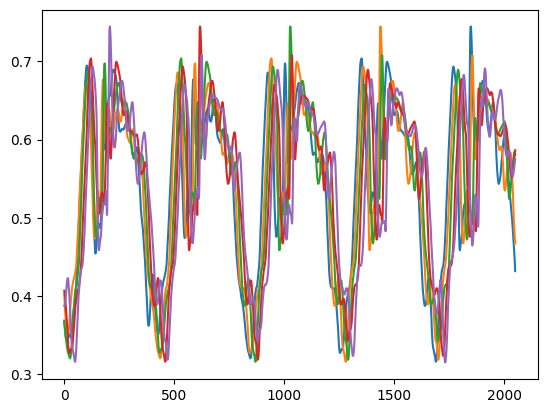

In [24]:
for i in range(5):
    plt.plot(df_train['gyroscope_x'].values[410*i : 410*i + 410 * 5])

## XGBoost

In [12]:
model = xgb.XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

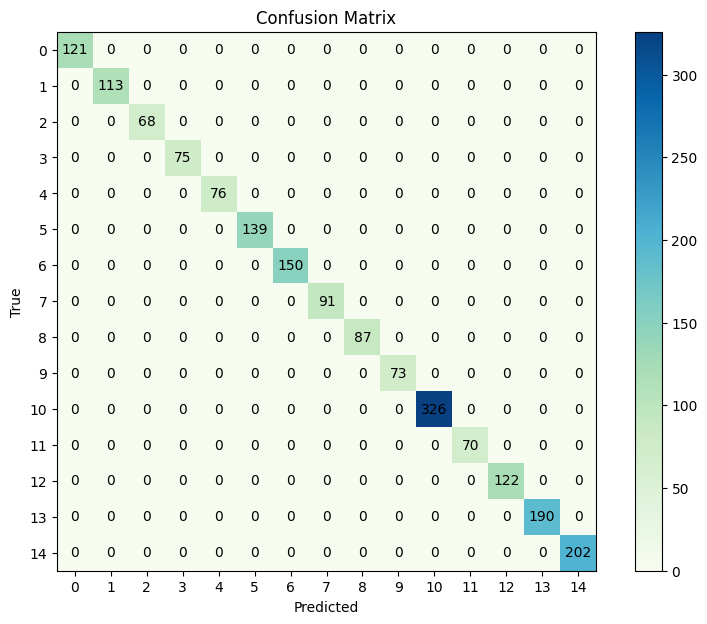

In [13]:
# Compute the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(cm, cmap='GnBu') # Blues
fig.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(np.arange(cm.shape[0]))
ax.set_yticklabels(np.arange(cm.shape[1]))
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted')
plt.ylabel('True')


# Add annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.show()

<Axes: >

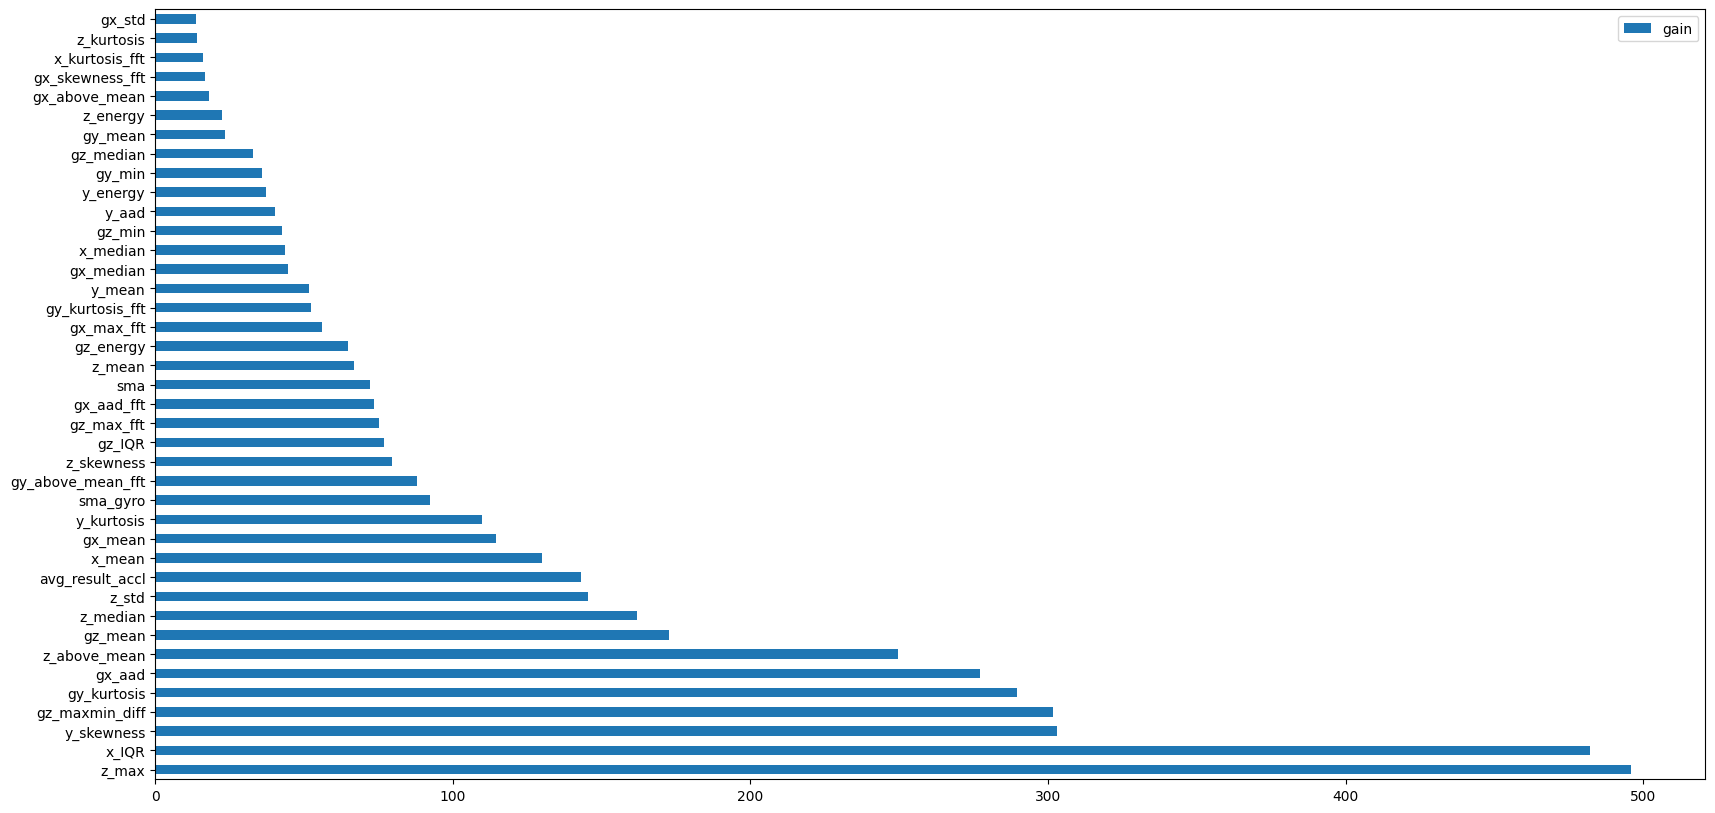

In [14]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by = "gain", ascending=False)
data.nlargest(40, columns="gain").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [15]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       113
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00       139
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        87
           9       1.00      1.00      1.00        73
          10       1.00      1.00      1.00       326
          11       1.00      1.00      1.00        70
          12       1.00      1.00      1.00       122
          13       1.00      1.00      1.00       190
          14       1.00      1.00      1.00       202

    accuracy                           1.00      1903
   macro avg       1.00      1.00      1.00      1903
weighted avg       1.00   

## Logistic Regression

In [16]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga', C=0.05, random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       113
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00       139
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        87
           9       1.00      1.00      1.00        73
          10       1.00      1.00      1.00       326
          11       1.00      1.00      1.00        70
          12       1.00      1.00      1.00       122
          13       1.00      1.00      1.00       190
          14       1.00      1.00      1.00       202

    accuracy                           1.00      1903
   macro avg   

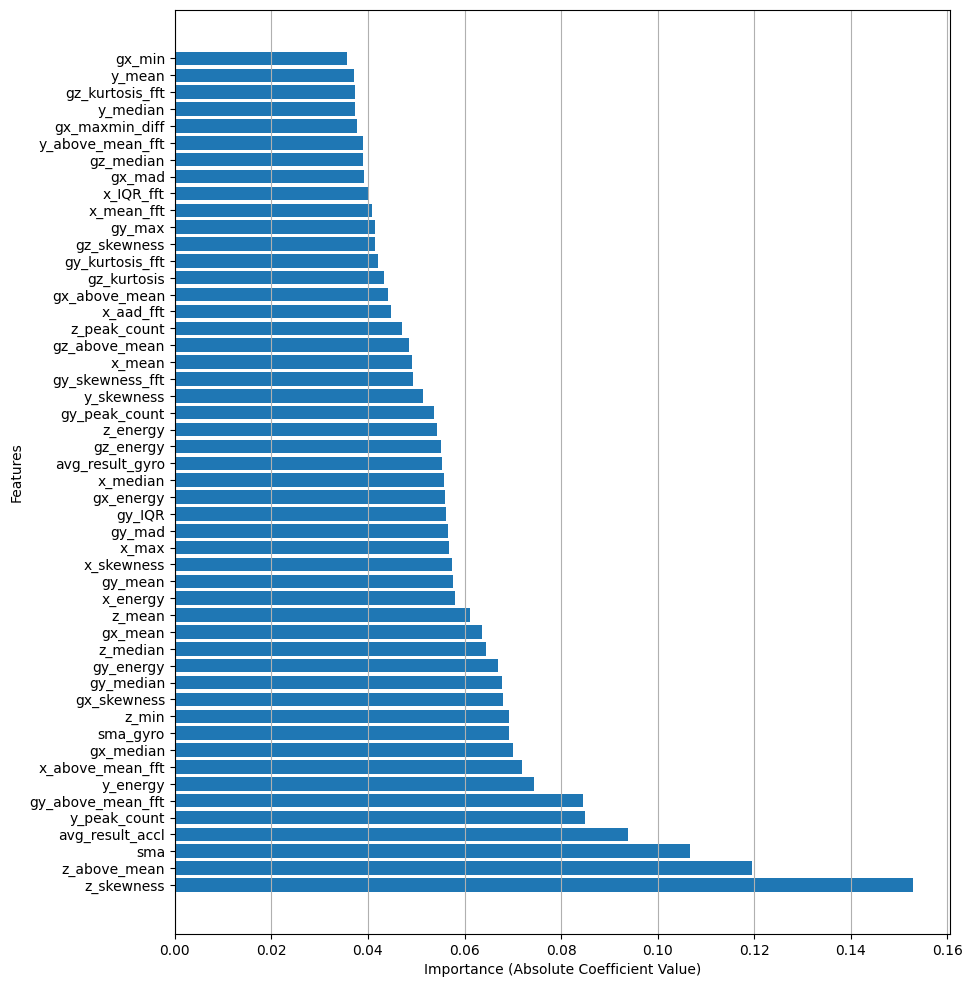

Feature: z_skewness, Coefficient: 0.15285109099817262, Importance: 0.15285109099817262
Feature: z_above_mean, Coefficient: 0.1194866334660922, Importance: 0.1194866334660922
Feature: sma, Coefficient: 0.10676881340595828, Importance: 0.10676881340595828
Feature: avg_result_accl, Coefficient: 0.09380559092909173, Importance: 0.09380559092909173
Feature: y_peak_count, Coefficient: 0.08492769405111736, Importance: 0.08492769405111736
Feature: gy_above_mean_fft, Coefficient: 0.08451308957399778, Importance: 0.08451308957399778
Feature: y_energy, Coefficient: 0.07441844978281699, Importance: 0.07441844978281699
Feature: x_above_mean_fft, Coefficient: 0.07198569713304363, Importance: 0.07198569713304363
Feature: gx_median, Coefficient: 0.07004816435614043, Importance: 0.07004816435614043
Feature: sma_gyro, Coefficient: 0.06929098984884105, Importance: 0.06929098984884105
Feature: z_min, Coefficient: 0.06921385555814046, Importance: 0.06921385555814046
Feature: gx_skewness, Coefficient: 0.067

In [17]:
# Feature importance
feature_names = X_train.columns
coefficients = np.abs(lr.coef_).mean(0)
importance = np.abs(coefficients)

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
sorted_importance = importance[sorted_indices]

# Select top 40 features
top_n = 50 # 188
top_features = sorted_features[:top_n]
top_coefficients = sorted_coefficients[:top_n]
top_importance = sorted_importance[:top_n]

# Create horizontal bar chart
plt.figure(figsize=(10, 12))
plt.barh(range(len(top_features)), top_importance, tick_label=top_features)
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
#plt.title('Top 40 Feature Importance in Logistic Regression')
plt.grid(axis='x')
plt.show()

for feature, coef, imp in zip(top_features, top_coefficients, top_importance):
    print(f"Feature: {feature}, Coefficient: {coef}, Importance: {imp}")

## Train with less features (Occams Razor)

In [18]:
lr = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga', C=0.05, random_state=21)
lr.fit(np.array(X_train[top_features]), y_train)

y_pred = lr.predict(np.array(X_test[top_features]))
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred, average='weighted')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       0.97      1.00      0.98       113
           2       1.00      0.99      0.99        68
           3       1.00      0.97      0.99        75
           4       0.94      0.99      0.96        76
           5       0.88      1.00      0.94       139
           6       0.96      0.89      0.93       150
           7       1.00      0.98      0.99        91
           8       1.00      0.64      0.78        87
           9       1.00      0.99      0.99        73
          10       0.91      0.98      0.94       326
          11       0.99      1.00      0.99        70
          12       0.99      0.98      0.98       122
          13       0.94      1.00      0.97       190
          14       1.00      0.92      0.96       202

    accuracy                           0.96      1903
   macro avg       0.97      0.95      0.96      1903
weighted avg       0.96   

0.9571714590935141

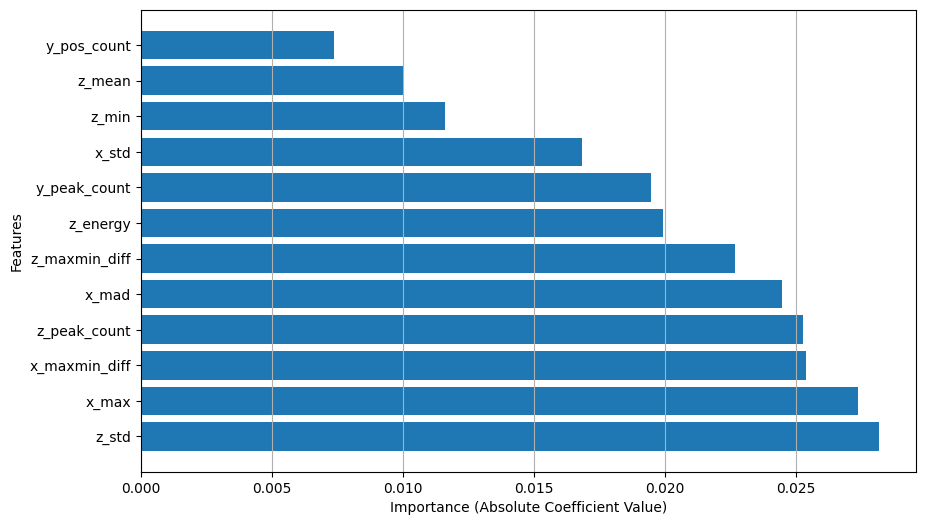

Feature: z_skewness, Coefficient: 0.028163791984847933, Importance: 0.028163791984847933
Feature: z_above_mean, Coefficient: 0.027359167722160762, Importance: 0.027359167722160762
Feature: sma, Coefficient: 0.025385192337966166, Importance: 0.025385192337966166
Feature: avg_result_accl, Coefficient: 0.025276189471511456, Importance: 0.025276189471511456
Feature: y_peak_count, Coefficient: 0.024468289426765228, Importance: 0.024468289426765228
Feature: gy_above_mean_fft, Coefficient: 0.02266994241515814, Importance: 0.02266994241515814
Feature: y_energy, Coefficient: 0.019940435107041025, Importance: 0.019940435107041025
Feature: x_above_mean_fft, Coefficient: 0.019458469575270695, Importance: 0.019458469575270695
Feature: gx_median, Coefficient: 0.016844794816866234, Importance: 0.016844794816866234
Feature: sma_gyro, Coefficient: 0.01162648251073132, Importance: 0.01162648251073132
Feature: z_min, Coefficient: 0.010043063243410576, Importance: 0.010043063243410576
Feature: gx_skewness

In [19]:
# Feature importance
feature_names = X_train.columns
coefficients = np.abs(lr.coef_).mean(0)
importance = np.abs(coefficients)

# Sort features by importance
sorted_indices = np.argsort(importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
sorted_importance = importance[sorted_indices]

# Select top 40 features
top_n = 12 # 188
top_features_ = sorted_features[:top_n]
top_coefficients = sorted_coefficients[:top_n]
top_importance = sorted_importance[:top_n]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_)), top_importance, tick_label=top_features_)
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
#plt.title('Top 40 Feature Importance in Logistic Regression')
plt.grid(axis='x')
plt.show()

for feature, coef, imp in zip(top_features, top_coefficients, top_importance):
    print(f"Feature: {feature}, Coefficient: {coef}, Importance: {imp}")

## Log. Regression F1-Score depending on N participants Plot

In [261]:
# Function to calculate 95% confidence interval
def conf_interval(data, confidence=0.95):
    a = np.array(data)
    mean = np.mean(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., len(a)-1)
    return mean, mean-h, mean+h

100%|███████████████████████████████████████████████████████████████████████████████████████████| 13/13 [11:21<00:00, 52.44s/it]


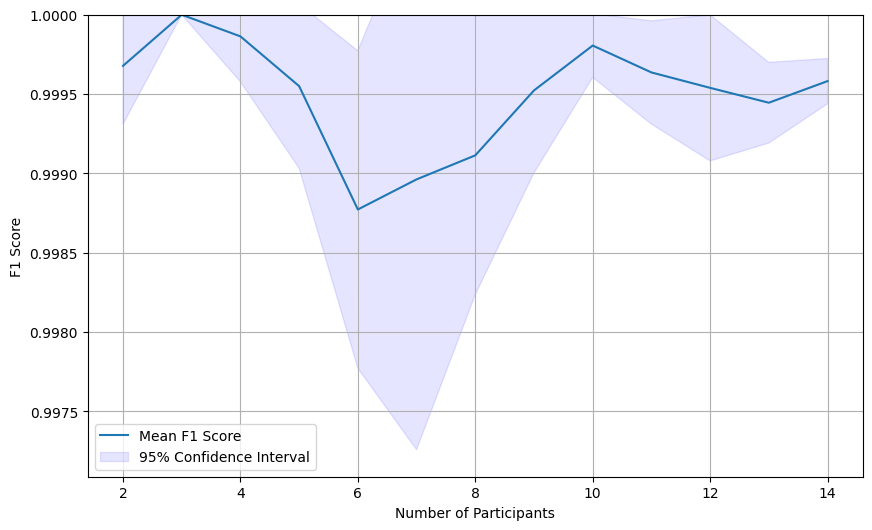

In [273]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils import resample
import scipy.stats

# Assuming X_train, X_test, y_train, y_test are already defined and min-max normalized

# Function to calculate 95% confidence interval
def conf_interval(data, confidence=0.95):
    a = np.array(data)
    mean = np.mean(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., len(a)-1)
    return mean, mean-h, mean+h

# Placeholder to store F1 scores for each class count
f1_scores_dict = {i: [] for i in range(2, 15)}

# Iterate from 2 to 14 classes
for num_classes in tqdm(range(2, 15)):
    for _ in range(20):  # Perform 10 random samples
        # Randomly sample classes to keep
        sampled_classes = resample(np.unique(y_train), n_samples=num_classes, replace=False)
        
        # Filter data for these classes
        train_indices = np.isin(y_train, sampled_classes)
        test_indices = np.isin(y_test, sampled_classes)
        
        X_train_sampled = X_train[train_indices]
        y_train_sampled = y_train[train_indices]
        X_test_sampled = X_test[test_indices]
        y_test_sampled = y_test[test_indices]
        
        # Train the logistic regression model
        lr = LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga', C=0.05, random_state=21)
        lr.fit(X_train_sampled, y_train_sampled)
        
        # Predict and calculate F1 score
        y_pred = lr.predict(X_test_sampled)
        f1 = f1_score(y_test_sampled, y_pred, average='weighted')
        
        # Append the F1 score
        f1_scores_dict[num_classes].append(f1)

# Calculate mean and 95% confidence intervals for F1 scores
f1_means = []
conf_intervals = []

for num_classes in range(2, 15):
    mean, lower, upper = conf_interval(f1_scores_dict[num_classes])
    f1_means.append(mean)
    conf_intervals.append((lower, upper))

# Plotting the F1 scores with 95% confidence intervals
plt.figure(figsize=(10, 6))
x = range(2, 15)
f1_means = np.array(f1_means)
conf_intervals = np.array(conf_intervals)
plt.plot(x, f1_means, label='Mean F1 Score')
plt.fill_between(x, conf_intervals[:, 0], conf_intervals[:, 1], color='b', alpha=0.1, label='95% Confidence Interval')
plt.xlabel('Number of ParticiIpants')
plt.ylabel('F1 Score')
#plt.title('F1 Score vs Number of Classes with 95% Confidence Interval')
plt.ylim(None,1)
plt.legend()
plt.grid(True)
plt.show()



## Autoencoder

In [28]:
import tensorflow as tf

2024-06-30 21:03:35.265282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 21:03:35.306644: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [185]:
# Define the dimensions
input_dim = X_train.shape[1]
latent_dim = 2

# Define the encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(latent_dim)  # No activation for direct latent representation
])

# Define the decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(latent_dim,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')  # Sigmoid to match input range
])

# Combine encoder and decoder into autoencoder
autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.output))

# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')

# Print summary
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 188)]             0         
                                                                 
 dense_662 (Dense)           (None, 256)               48384     
                                                                 
 dense_663 (Dense)           (None, 256)               65792     
                                                                 
 dense_664 (Dense)           (None, 256)               65792     
                                                                 
 dense_665 (Dense)           (None, 256)               65792     
                                                                 
 dense_666 (Dense)           (None, 256)               65792     
                                                                 
 dense_667 (Dense)           (None, 256)               657

In [186]:
# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=512, validation_split=0.01)

Epoch 1/50
18/18 [==============================] - 2s 10ms/step - loss: 0.2661 - val_loss: 0.1424
Epoch 2/50
18/18 [==============================] - 0s 7ms/step - loss: 0.1143 - val_loss: 0.1047
Epoch 3/50
18/18 [==============================] - 0s 7ms/step - loss: 0.1018 - val_loss: 0.1003
Epoch 4/50
18/18 [==============================] - 0s 10ms/step - loss: 0.0999 - val_loss: 0.1002
Epoch 5/50
18/18 [==============================] - 0s 11ms/step - loss: 0.0994 - val_loss: 0.0998
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0993 - val_loss: 0.0999
Epoch 7/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0993 - val_loss: 0.0999
Epoch 8/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0992 - val_loss: 0.0998
Epoch 9/50
18/18 [==============================] - 0s 11ms/step - loss: 0.0992 - val_loss: 0.0996
Epoch 10/50
18/18 [==============================] - 0s 9ms/step - loss: 0.0984 - val_loss: 0.0986
Epoch 11/50
18/

289/289 [==============================] - 0s 689us/step


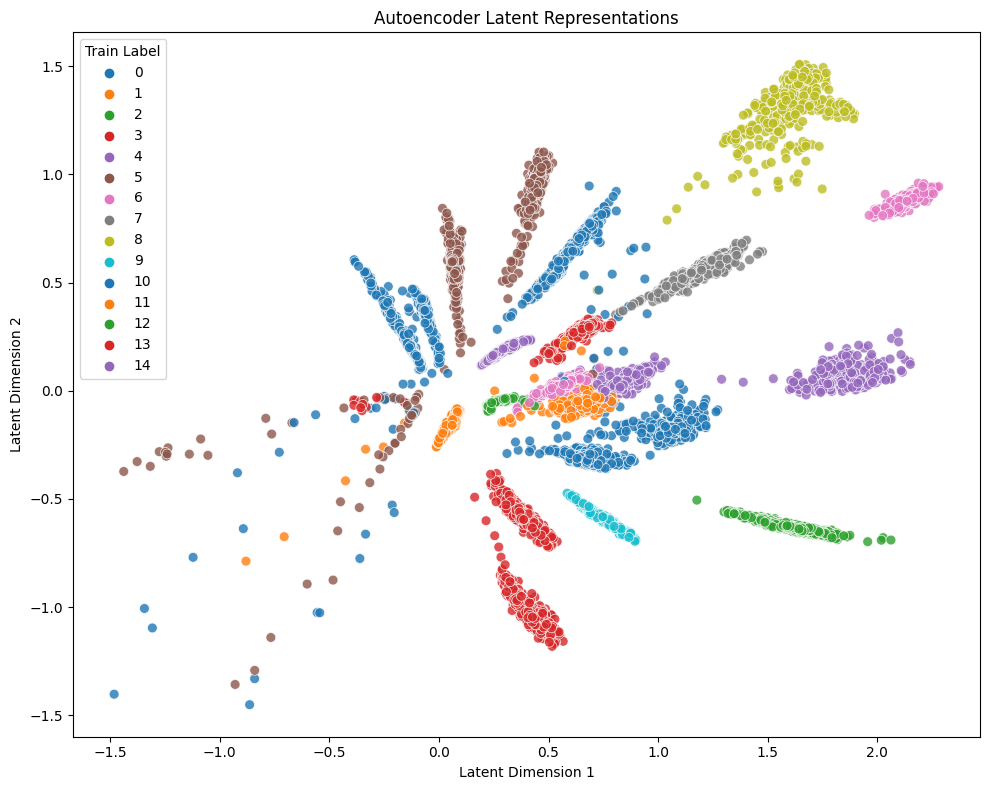

In [187]:
encoded_train = encoder.predict(X_train)

# Plotting the encoded_train (latent representations) with y_train as color
plt.figure(figsize=(10, 8))
sns.scatterplot(x=encoded_train[:, 0], y=encoded_train[:, 1], hue=y_train, palette='tab10', s=50, alpha=0.8)
plt.title('Autoencoder Latent Representations')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend(title='Train Label', loc='best')
plt.tight_layout()
plt.show()

## VAE

In [208]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [258]:
# Define the dimensions
input_dim = X_train.shape[1]
latent_dim = 2

# Sampling function for the latent space
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

# Define the encoder
inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Define the decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Define the VAE
outputs = decoder(z)
vae = Model(inputs, outputs, name='vae')

# Define the VAE loss
reconstruction_loss = tf.keras.losses.mse(inputs, outputs) * input_dim
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + 0.6 * kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
#vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_108 (InputLayer)         [(None, 188)]        0           []                               
                                                                                                  
 dense_960 (Dense)              (None, 128)          24192       ['input_108[0][0]']              
                                                                                                  
 dense_961 (Dense)              (None, 128)          16512       ['dense_960[0][0]']              
                                                                                                  
 dense_962 (Dense)              (None, 128)          16512       ['dense_961[0][0]']              
                                                                                            

In [259]:
# Train the VAE
history = vae.fit(X_train, X_train, epochs=100, batch_size=512, validation_split=0.1)

Epoch 1/100
17/17 [==============================] - 2s 10ms/step - loss: 11.2121 - val_loss: 6.6655
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 5.2070 - val_loss: 4.4997
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 4.3349 - val_loss: 4.1546
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 4.1276 - val_loss: 4.0460
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 4.0697 - val_loss: 4.0179
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 4.0536 - val_loss: 4.0173
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 4.0424 - val_loss: 4.0151
Epoch 8/100
17/17 [==============================] - 0s 8ms/step - loss: 4.0455 - val_loss: 4.0138
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 4.0519 - val_loss: 4.0188
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 4.0479 - val_loss: 4.0119
Epoch 1

Epoch 83/100
17/17 [==============================] - 0s 6ms/step - loss: 4.0361 - val_loss: 4.0136
Epoch 84/100
17/17 [==============================] - 0s 3ms/step - loss: 4.0478 - val_loss: 4.0136
Epoch 85/100
17/17 [==============================] - 0s 8ms/step - loss: 4.0521 - val_loss: 4.0085
Epoch 86/100
17/17 [==============================] - 0s 8ms/step - loss: 4.0532 - val_loss: 4.0154
Epoch 87/100
17/17 [==============================] - 0s 6ms/step - loss: 4.0390 - val_loss: 4.0129
Epoch 88/100
17/17 [==============================] - 0s 6ms/step - loss: 4.0512 - val_loss: 4.0192
Epoch 89/100
17/17 [==============================] - 0s 6ms/step - loss: 4.0450 - val_loss: 4.0124
Epoch 90/100
17/17 [==============================] - 0s 9ms/step - loss: 4.0475 - val_loss: 4.0176
Epoch 91/100
17/17 [==============================] - 0s 4ms/step - loss: 4.0410 - val_loss: 4.0134
Epoch 92/100
17/17 [==============================] - 0s 7ms/step - loss: 4.0429 - val_loss: 4.0119


289/289 [==============================] - 0s 766us/step


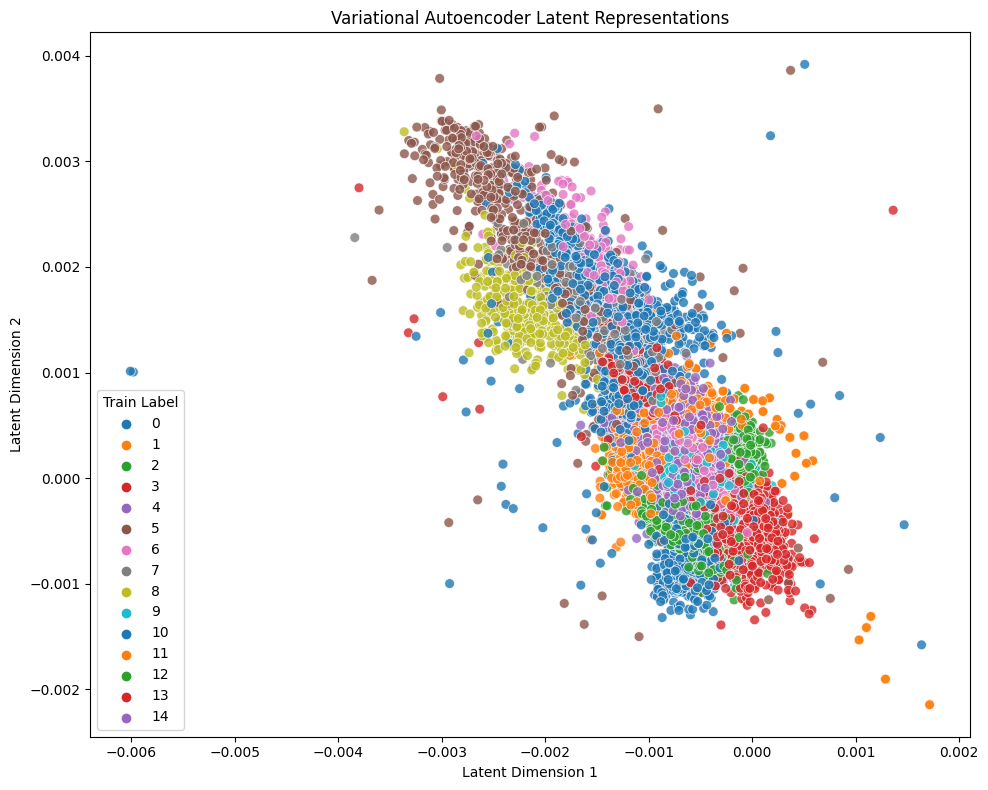

In [260]:
# Obtain the latent representations (encodings) for X_train
z_mean, _, _ = encoder.predict(X_train)

# Plot the encodings with y_train as color
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z_mean[:, 0], y=z_mean[:, 1], hue=y_train, palette='tab10', s=50, alpha=0.8)
plt.title('Variational Autoencoder Latent Representations')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend(title='Train Label', loc='best')
plt.tight_layout()
plt.show()

## t-SNE

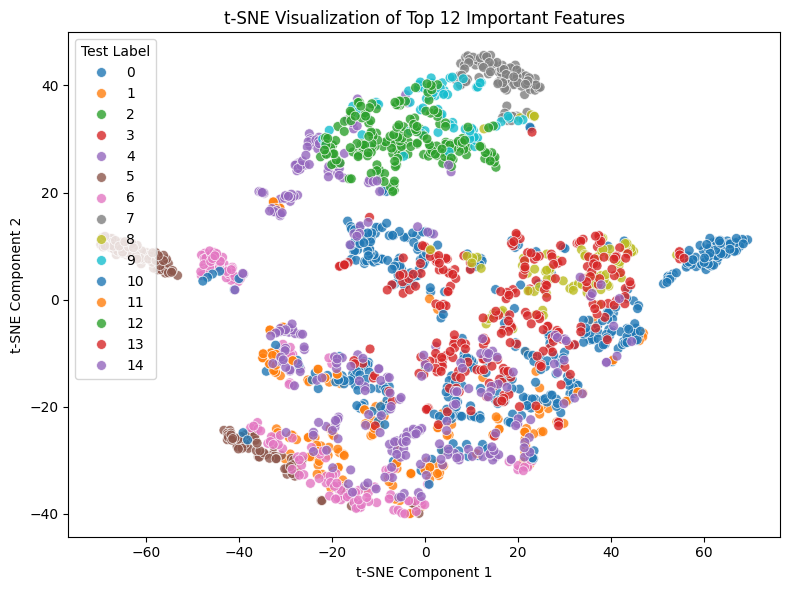

In [28]:
X_top_features = X_test[top_features_]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_top_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_test, palette='tab10', s=50, alpha=0.8)
plt.title('t-SNE Visualization of Top 12 Important Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Test Label', loc='best')
plt.tight_layout()
plt.show()

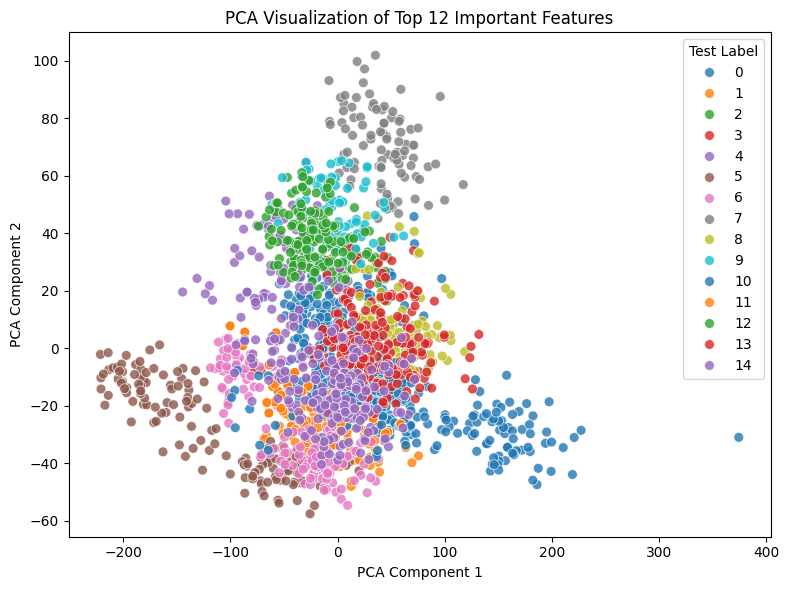

In [66]:
X_top_features = X_test[top_features_]
# Step 2: Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_top_features)

# Step 3: Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='tab10', s=50, alpha=0.8)
plt.title('PCA Visualization of Top 12 Important Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Test Label', loc='best')
plt.tight_layout()
plt.show()


## Tuning

In [278]:
import wandb

In [285]:
def train_evaluate(config=None):
    with wandb.init(config=config):
        config = wandb.config

        lr = LogisticRegression(
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            C=config.C,
            random_state=42
        )
        lr.fit(np.array(X_train[top_features]), y_train)
        
        y_pred = lr.predict(np.array(X_val[top_features]))
        val_f1 = f1_score(y_val, y_pred, average='weighted')
        
        wandb.log({"val_f1": val_f1})
        print(classification_report(y_val, y_pred))


sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_f1',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {
            'distribution': 'log_uniform_values',
            'min': 0.0001,
            'max': 1.0
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, entity='ds4w', project='ds4w')
wandb.agent(sweep_id, function=train_evaluate, count=30)

Create sweep with ID: vfjumq0e
Sweep URL: https://wandb.ai/ds4w/ds4w/sweeps/vfjumq0e


wandb: Agent Starting Run: eni2rs2c with config:
wandb: 	C: 0.10244752418181428


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mh8hxqdn with config:
wandb: 	C: 0.009492809277979075


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3pw67hid with config:
wandb: 	C: 0.003953814544660583


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.95      0.96       213
           9       0.78      0.70      0.74        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.88      0.88      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97816


wandb: Agent Starting Run: u0xz2lwf with config:
wandb: 	C: 0.03609408737066498


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Agent Starting Run: qxvv0djy with config:
wandb: 	C: 0.001872831608753394


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.91      1.00      0.95        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: je9vzrgo with config:
wandb: 	C: 0.0015828411637242947


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.93      1.00      0.96        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.9812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 06y61frn with config:
wandb: 	C: 0.00014119282426796904


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       101
           1       0.98      0.87      0.92        68
           2       1.00      0.96      0.98        54
           3       1.00      1.00      1.00        45
           4       1.00      0.76      0.86        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           8       0.92      0.96      0.94       213
           9       0.75      0.60      0.67        10
          10       0.97      1.00      0.99        39
          11       0.99      1.00      0.99        86

    accuracy                           0.96       761
   macro avg       0.96      0.92      0.94       761
weighted avg       0.96      0.96      0.96       761



val_f1,▁
val_f1,0.96095


wandb: Agent Starting Run: ollzuq52 with config:
wandb: 	C: 0.928104548435592


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ks4ahuth with config:
wandb: 	C: 0.0011218687557745413


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.97      0.97      0.97       213
           9       1.00      0.70      0.82        10
          10       0.93      1.00      0.96        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.99      0.98      0.98       761



val_f1,▁
val_f1,0.98319


wandb: Agent Starting Run: l4pza27p with config:
wandb: 	C: 0.000890253939365445


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       0.98      0.93      0.95        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.97      0.97      0.97       213
           9       1.00      0.70      0.82        10
          10       0.95      1.00      0.97        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98051


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idx8yzg0 with config:
wandb: 	C: 0.001653507274963952


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.91      1.00      0.95        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97991


wandb: Agent Starting Run: oypqfkfc with config:
wandb: 	C: 0.10914996707591


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tgnys8hy with config:
wandb: 	C: 0.002126440400236395


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97933


wandb: Agent Starting Run: 7lkedink with config:
wandb: 	C: 0.006073779838944279


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.70      0.70      0.70        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.87      0.88      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b7yfrtfj with config:
wandb: 	C: 0.0020807721389171515


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97933


wandb: Agent Starting Run: pguv2634 with config:
wandb: 	C: 0.7310716371996069


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0yuh2px with config:
wandb: 	C: 0.000917011800531729


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       0.98      0.93      0.95        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.97      0.97      0.97       213
           9       1.00      0.70      0.82        10
          10       0.95      1.00      0.97        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98051


wandb: Agent Starting Run: fuemxs85 with config:
wandb: 	C: 0.02819254345486232


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65re2uy3 with config:
wandb: 	C: 0.0005144572370019174


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       0.98      0.90      0.94        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.96      0.98        25
           5       0.97      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.96      0.98      0.97       213
           9       1.00      0.70      0.82        10
          10       1.00      1.00      1.00        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98043


wandb: Agent Starting Run: bdg3ahno with config:
wandb: 	C: 0.00010387031057925876


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       101
           1       0.87      0.81      0.84        68
           2       0.98      0.94      0.96        54
           3       1.00      1.00      1.00        45
           4       1.00      0.64      0.78        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           8       0.89      0.93      0.91       213
           9       1.00      0.40      0.57        10
          10       0.95      1.00      0.97        39
          11       0.98      1.00      0.99        86

    accuracy                           0.94       761
   macro avg       0.96      0.88      0.91       761
weighted avg       0.94      0.94      0.94       761



val_f1,▁
val_f1,0.93673


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbgcv8tv with config:
wandb: 	C: 0.005038251631365378


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.70      0.70      0.70        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.87      0.88      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97698


wandb: Agent Starting Run: oy8ngukj with config:
wandb: 	C: 0.0002969604454539146


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       0.98      0.88      0.93        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       1.00      0.92      0.96        25
           5       0.98      1.00      0.99       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.95      0.98      0.96       213
           9       1.00      0.70      0.82        10
          10       1.00      1.00      1.00        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.91      0.87      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97711


wandb: Agent Starting Run: m2wfpdq8 with config:
wandb: 	C: 0.12251224740289764


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jh4mye06 with config:
wandb: 	C: 0.0024026256509371


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.89      1.00      0.94        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.98067


wandb: Agent Starting Run: kui170a9 with config:
wandb: 	C: 0.5979610588182281


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 121rw2r4 with config:
wandb: 	C: 0.001586937025947154


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.93      0.96        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       0.99      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.96      0.97       213
           9       1.00      0.70      0.82        10
          10       0.93      1.00      0.96        39
          11       0.99      1.00      0.99        86

    accuracy                           0.98       761
   macro avg       0.90      0.88      0.89       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.9812


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4pgqnbw6 with config:
wandb: 	C: 0.7308061006723315


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Agent Starting Run: fed6v7f7 with config:
wandb: 	C: 0.2729599911471942


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rg4791ua with config:
wandb: 	C: 0.016072938230801474


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3r90n403 with config:
wandb: 	C: 0.05999797385688894


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      0.94      0.97        68
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        45
           4       0.93      1.00      0.96        25
           5       1.00      1.00      1.00       107
           6       1.00      1.00      1.00        13
           7       0.00      0.00      0.00         0
           8       0.98      0.94      0.96       213
           9       0.67      0.80      0.73        10
          10       0.89      1.00      0.94        39
          11       1.00      1.00      1.00        86

    accuracy                           0.98       761
   macro avg       0.87      0.89      0.88       761
weighted avg       0.98      0.98      0.98       761



val_f1,▁
val_f1,0.97864


In [ ]:
# best C: 0.001